![example](images/director_shot.jpeg)

# Determining Optimal Attributes for a Movie Release

**Authors:** Cameron T Ladd, Ji Hoon Chung
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

1. What is the most profitable kind of movie by genre?
2. What is the optimal runtime of each movie per genre?
3. What season is the best time to release per genre?

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

## IMPORT MODULES

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

%matplotlib inline

In [2]:
# Examine data folder contents
# !ls data/zippedData

## IMPORT ALL DATA

In [3]:
#Box Office Mojo Data (bom)
bom_moviegross_df = pd.read_csv('data/zippedData/bom.movie_gross.csv.gz')

#IMDB Data (imdb)
imdb_title_basics_df = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')

#The Numbers (tn)
tn_movie_budgets_df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

## PREVIEW DataFrames IN USE

In [4]:
# bom_moviegross_df.head()

In [5]:
# imdb_title_basics_df.head()

In [6]:
# tn_movie_budgets_df.head()

## CHECK FOR MISSING VALUES

In [7]:
# bom_moviegross_df.isna().sum()

In [8]:
# imdb_title_basics_df.isna().sum()

In [9]:
# tn_movie_budgets_df.isna().sum()

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

## Box Office Mojo Data

In [10]:
# bom_moviegross_df.info()

In [11]:
# bom_moviegross_df['foreign_gross'].describe()

In [12]:
# bom_moviegross_df.isna().sum()

In [13]:
# bom_moviegross_df['foreign_gross'].shape

In [14]:
# Find percentage of null values to determine dataset viability
num_missing_bom_foreigngross = bom_moviegross_df.isna().sum()['foreign_gross']
total_moviegross_entries = len(bom_moviegross_df['foreign_gross'])
percentage_missing_foreign = num_missing_bom_foreigngross / total_moviegross_entries
print(percentage_missing_foreign)

0.3985828166519043


In [15]:
print(len(list(bom_moviegross_df['foreign_gross'].unique())))
non_standard = []
for x in list(bom_moviegross_df['foreign_gross'].unique()):
    if type(x) != int and type(x) != float:
        non_standard.append(x)
    else:
        pass

1205


In [16]:
# Find length of new non-standard list so we know how many of the uniques are floats or ints (just one)
print(len(non_standard))
# Find out if any of the unique values AREN'T strings
[type(x) for x in non_standard if type(x) != str]

1204


[]

Let's summarize what we have so far:
    
    3387 total entries
    1350 null values
    1204 str type values

This leaves:
    
    833 int/float type values

In [17]:
# Converted from str, int, float to exclusively float
foreign_gross_numeric = pd.to_numeric(bom_moviegross_df['foreign_gross'], errors = 'coerce', downcast = 'float') 
# Assigned new series in place of original df series
bom_moviegross_df['foreign_gross'] = foreign_gross_numeric
# bom_moviegross_df['foreign_gross'].describe()

In [18]:
# Adjust the dataset by filling NaN values with the mean (filling it with the median changed the dataset's descriptive statistics much too drastically)
foreign_gross_mean = bom_moviegross_df['foreign_gross'].mean()
mean_adjusted = bom_moviegross_df['foreign_gross'].fillna(foreign_gross_mean)
# Remove all entries with domestic or foreign gross less than 1,000,000, since this is a large company we are concerned with
mean_adjusted_removed = bom_moviegross_df[(bom_moviegross_df['foreign_gross'] > 1000000) & (bom_moviegross_df['domestic_gross'] > 1000000)]
# mean_adjusted.describe()

In [19]:
# Remove entries that don't have a domestic gross value, since it only constitutes a small portion of the data
mean_adjusted_removed.dropna(axis=0, how='any', inplace=True)
# Drop columns that will not be used
mean_adjusted_removed.drop('year', axis=1, inplace=True)
mean_adjusted_removed.drop('studio', axis=1, inplace=True)

<ipython-input-19-fcbb0c5d7930>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_adjusted_removed.dropna(axis=0, how='any', inplace=True)
C:\Users\camla\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
# Assign the cleaned dataframe a new index and variable
final_moviegross_df = mean_adjusted_removed.set_index('title')
final_moviegross_df['total_gross'] = final_moviegross_df['domestic_gross'] + final_moviegross_df['foreign_gross']

In [21]:
# final_moviegross_df

## IMDB Title_basics data

Let's clean the imdb_title_basics_df

In [22]:
# imdb_title_basics_df

In [23]:
# Set index to primary_title for merging later
imdb_title_index = imdb_title_basics_df.set_index('primary_title')
# Drop unused columns
imdb_title_index_dropped = imdb_title_index.drop(['tconst', 'original_title', 'start_year'], axis=1)
# Drop entries that have missing values (there are very few and we need all values for our analysis)
imdb_title_index_removedna = imdb_title_index_dropped.dropna(axis=0, how = 'any')
# Assign cleaned DataFrame to new variable
final_imdb_title_df = imdb_title_index_removedna

Here are the two DataFrames we have so far:

In [24]:
# final_imdb_title_df

In [25]:
# final_moviegross_df

## tn_movie_budgets_df

In [26]:
# Stripping dollar signs from the series
tn_movie_budgets_df['production_budget'] = tn_movie_budgets_df['production_budget'].map(lambda x: x.lstrip('$'))
tn_movie_budgets_df['domestic_gross'] = tn_movie_budgets_df['domestic_gross'].map(lambda x: x.lstrip('$'))
tn_movie_budgets_df['worldwide_gross'] = tn_movie_budgets_df['worldwide_gross'].map(lambda x: x.lstrip('$'))
# Remove the commas from the series
tn_movie_budgets_df.loc[:, "production_budget":"worldwide_gross"] = tn_movie_budgets_df.loc[:, "production_budget":"worldwide_gross"].replace(",","", regex=True).astype('int64')
# Rename the columns
tn_movie_budgets_df.rename(columns = {'movie':"primary_title"}, inplace = True)
final_imdb_title_df.rename(columns = {'primary_title':"title"}, inplace = True)

C:\Users\camla\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


## Merging the data

In [27]:
# Perform inner merge
final_df = tn_movie_budgets_df.merge(final_imdb_title_df, on= 'primary_title', how= 'inner')
# Create a total_gross column for further understanding of the data
final_df["total_gross"] = final_df["domestic_gross"] + final_df["worldwide_gross"]

In [37]:
# final_df

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

comment on my code

## Total gross per genre (Mean and Median Adjusted)

In [29]:
# Stack the genres columns after removing the columns (must set expand=True so that it returns a DataFrame rather thana series)
# Count the total occurences of each genre
count = final_df['genres'].str.split(',', expand=True).stack().value_counts()
# Copy final_df to another variable
genres = final_df.copy()

In [30]:
# Split genres into columns
genres[['genre1', 'genre2', 'genre3']] = final_df['genres'].str.split(',', expand=True)
# Calculate profit per movie
genres['profit'] = genres['total_gross'] - genres['production_budget']
# genres

In [31]:
# Find total world_wide, domestic_ gross, and total_gross for each genre across all entries

# Worldwide
genre1_worldwide_gross = genres.groupby('genre1')['worldwide_gross'].sum()
genre2_worldwide_gross = genres.groupby('genre2')['worldwide_gross'].sum()
genre3_worldwide_gross = genres.groupby('genre3')['worldwide_gross'].sum()
# Domestic
genre1_domestic_gross = genres.groupby('genre1')['domestic_gross'].sum()
genre2_domestic_gross = genres.groupby('genre2')['domestic_gross'].sum()
genre3_domestic_gross = genres.groupby('genre3')['domestic_gross'].sum()
# Total
genre1_total_gross = genres.groupby('genre1')['total_gross'].sum()
genre2_total_gross = genres.groupby('genre2')['total_gross'].sum()
genre3_total_gross = genres.groupby('genre3')['total_gross'].sum()

# Add the calculated values and drop insignificant genres

# Worldwide
genre_total_worldwide_gross = genre1_worldwide_gross.add(genre2_worldwide_gross, fill_value=0).add(genre3_worldwide_gross, fill_value=0)
final_genre_worldwide_gross = genre_total_worldwide_gross.drop(['News', 'Reality-TV'])
# Domestic
genre_total_domestic_gross = genre1_domestic_gross.add(genre2_domestic_gross, fill_value=0).add(genre3_domestic_gross, fill_value=0)
final_genre_total_domestic_growth = genre_total_domestic_gross.drop(['News', 'Reality-TV'])
# Total
genre_total_gross = genre1_total_gross.add(genre2_total_gross, fill_value=0).add(genre3_total_gross, fill_value=0)
final_genre_total_gross = genre_total_gross.drop(['News', 'Reality-TV'])

In [32]:
#Concatenate series into a useable DataFrame, rename index
final_gross_df = pd.concat([final_genre_total_domestic_growth, final_genre_worldwide_gross, final_genre_total_gross], axis=1).reset_index()
final_gross_df_cleaned = final_gross_df.set_index('index')
final_gross_df_cleaned.index.name = 'Genre'
# final_gross_df_cleaned

Now I will make a stacked bar graph!!! Each genre's bar will be split by "domestic_gross" and "foreign_gross", equaling the total bar, which is total_gross

In [33]:
# Drop total_gross column on a copies DataFrame for easier plotting
bar_plotdata = final_gross_df_cleaned.drop('total_gross', axis=1)
# bar_plotdata

Text(0, 0.5, 'Gross (in 10s of billions of dollars)')

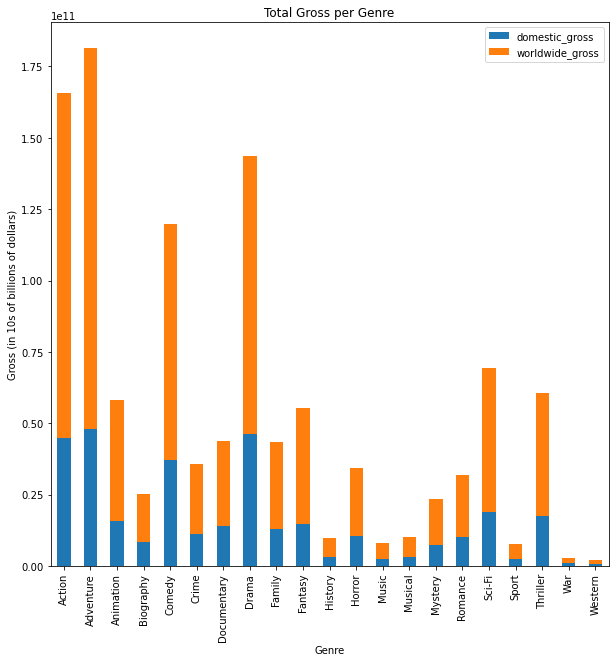

In [34]:
# Plot data
bar_plotdata.plot(kind='bar', stacked=True, figsize=(10,10))
plt.title('Total Gross per Genre')
plt.xlabel('Genre')
plt.ylabel('Gross (in 10s of billions of dollars)')

1. The visualization, and subsequent understanding, of the variations of gross revenue in movies from domestic and worldwide sales could be very insightful. When discussing the genre that grossed the most, 'Adventure', we can see that worldwide releases of adventure films seem to do markedly better than that of domestic releases. Therefore when releasing a movie from the 'Adventure' genre, it would be best to secure rights and begin advertisement in international countries early in order to maximize potential gross income and in consequence potential profit

## Total profit per genre

In [35]:
# Final total profit (Gross - Budget) for each genre
genre1_total_profit = genres.groupby('genre1')['profit'].sum()
genre2_total_profit = genres.groupby('genre2')['profit'].sum()
genre3_total_profit = genres.groupby('genre3')['profit'].sum()
# Sum up calculated values and drop insignificant genres
genre_overall_profit = genre1_total_profit.add(genre2_total_profit, fill_value=0).add(genre3_total_profit, fill_value=0)
final_genre_profit_df = genre_overall_profit.drop(['News', 'Reality-TV'])
# final_genre_profit_df

Text(0, 0.5, 'Profit (in 10s of billions of dollars)')

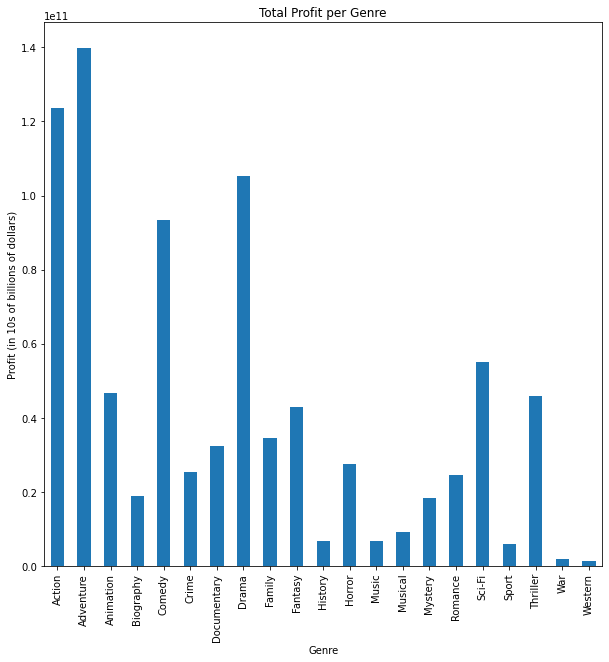

In [36]:
# Plot data
final_genre_profit_df.plot(kind='bar', stacked=True, figsize=(10,10))
plt.title('Total Profit per Genre')
plt.xlabel('Genre')
plt.ylabel('Profit (in 10s of billions of dollars)')

The profit distribution is identical to that of the gross revenue distribution. This visualization's purpose is to reinforce the concept that not only did Adventure movies gross more, but they also profited more, two very different concepts. The scale for this graph is less than that of the gross revenue graph, due to the fact that the budget has been subtracted from every single gross total per genre

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***